In [6]:
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader

from nn_utils import MapsDataset, ConvSimpleNet, train_validate, plot_train_val_loss


In [7]:
DIR = os.path.abspath("./dataset")
LABEL_MAPPER = {"Cars": 0, "Drones": 1, "People": 2}
INV_LABEL_MAPPER = {v: k for k, v in LABEL_MAPPER.items()}
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SEED = 0

def get_data_for_label(label):
    X, y = [], []
    for root, dirs, files in os.walk(os.path.join(DIR, label)):
        for file in files:
            if file.endswith('.csv'):
                y.append(LABEL_MAPPER[label])
                df = pd.read_csv(os.path.join(root, file), sep=',', header=None)
                X.append(df.values)
    print(f'Loaded {len(y)} examples for label {label} encoded with {LABEL_MAPPER[label]}')
    return X, y

# Load data
X_cars, y_cars = get_data_for_label('Cars')
X_drones, y_drones = get_data_for_label('Drones')
X_people, y_people = get_data_for_label('People')

# Combine data
X = X_cars + X_drones + X_people
y = y_cars + y_drones + y_people

# Ensure data exists
if not X or not y:
    raise ValueError("Data loading failed. Ensure dataset paths and files are correct.")

# Ensure all arrays in X have the same shape
# Optional: Replace with a preprocessing step if necessary
sample_shape = X[0].shape
if not all(arr.shape == sample_shape for arr in X):
    raise ValueError(f"Inconsistent array shapes in dataset. Example shape: {sample_shape}")

# Convert to NumPy arrays
X = np.stack(X, axis=0)  # Creates a (n_samples, height, width) array
y = np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")

Loaded 5720 examples for label Cars encoded with 0
Loaded 5065 examples for label Drones encoded with 1
Loaded 6700 examples for label People encoded with 2
X shape: (17485, 11, 61), y shape: (17485,)


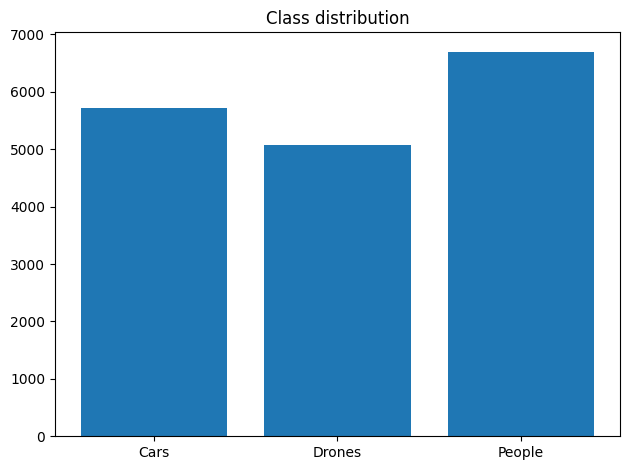

In [8]:
# classes = ['Cars', 'Drones', 'People']
# num_examples = [len(x) for x in [X_cars, X_drones, X_people]]
fig, ax = plt.subplots()
ax.bar(['Cars', 'Drones', 'People'], [len(x) for x in [y_cars, y_drones, y_people]])
ax.set_title('Class distribution')

plt.tight_layout()
plt.savefig("./figures/class_distribution.png", dpi=150)

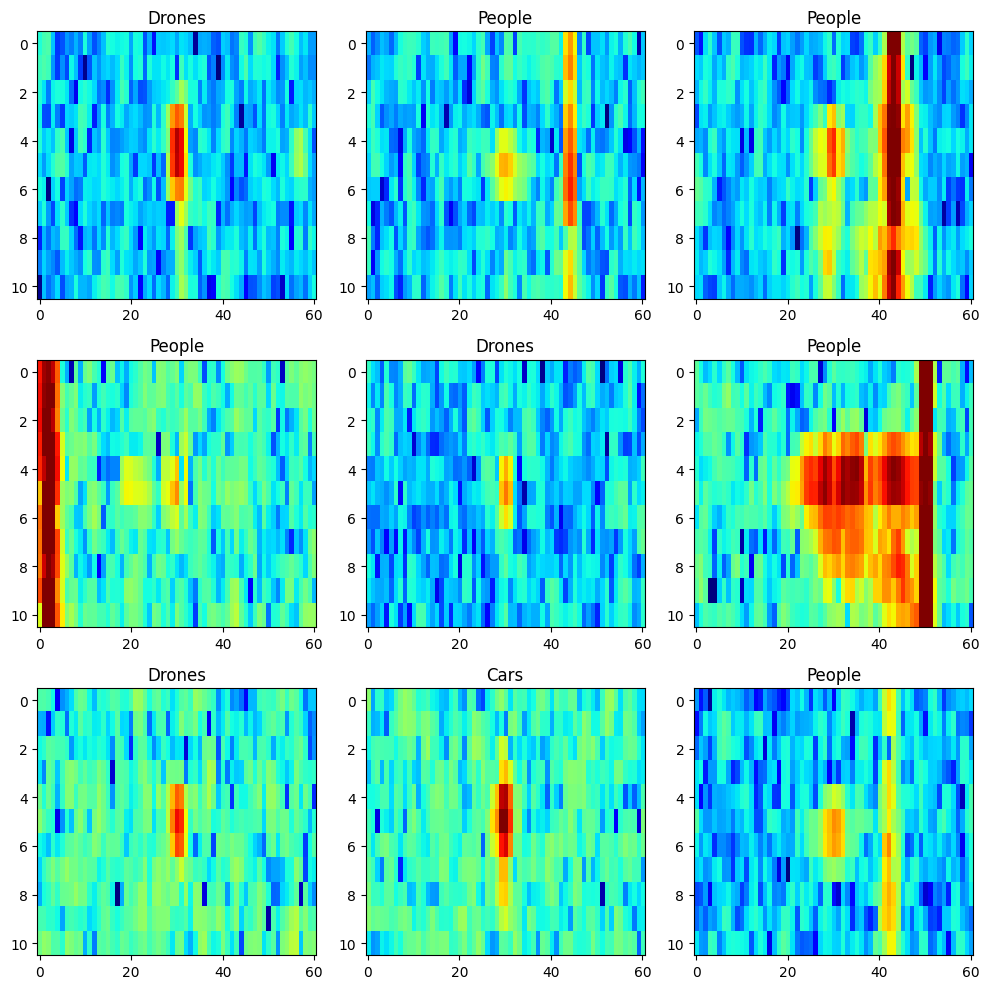

In [9]:
SEED = 27
# np.random.seed(SEED)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, j in itertools.product(range(3), range(3)):
    index = np.random.randint(0, len(y)-1)
    img = axs[i, j].imshow(X[index], cmap='jet', vmin=-140, vmax=-70)
    axs[i, j].set_title(f'{INV_LABEL_MAPPER[y[index]]}')
    axs[i, j].axis('tight')

plt.tight_layout()
plt.savefig("./figures/class_examples.png", dpi=150)

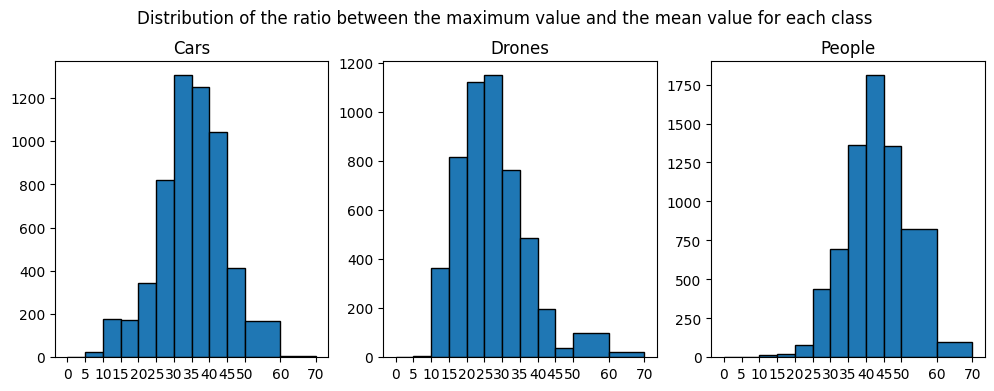

In [10]:
# It seems to be a wide dynamic range between the labels
# To dig into this issue we can explore the ratio between the maximum and mean value of the maps for each label

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(hspace=0.4, top=0.85)
BINS = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70]
for i, (label, value) in enumerate(LABEL_MAPPER.items()):
    X_label = X[np.where(y == value)]
    label_ratio = np.amax(X_label, (1, 2)) - np.mean(X_label, (1, 2))
    axs[i].hist(label_ratio, edgecolor = "black", bins=BINS)
    axs[i].set_xticks(BINS)
    axs[i].set_title(label)
fig.suptitle('Distribution of the ratio between the maximum value and the mean value for each class')
plt.show()